In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras import ops
import tensorflow as tf
import pickle

ModuleNotFoundError: No module named 'tensorflow.python.trackable'

In [2]:
num_classes = 22
latent_dim = 10
num_channels = 3
generator_channels = latent_dim + num_classes
discriminator_channels = num_classes + num_channels
batch_size = 128
image_size = 256

In [3]:
def load_data(batch_size=batch_size):
    train_data = keras.utils.image_dataset_from_directory("datasets/padded_training",
                                                            labels="inferred",
                                                            label_mode="categorical",
                                                            image_size=(256,256),
                                                            batch_size=batch_size)
    test_data = keras.utils.image_dataset_from_directory("datasets/padded_testing",
                                                            labels="inferred",
                                                            label_mode="categorical",
                                                            image_size=(256,256),
                                                            batch_size=batch_size)
    return train_data, test_data

In [4]:
train_data, test_data = load_data()
combined_data = train_data.concatenate(test_data)

Found 3300 files belonging to 22 classes.


2024-04-22 15:26:58.338226: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18211 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 3g.20gb, pci bus id: 0000:31:00.0, compute capability: 8.0


Found 3298 files belonging to 22 classes.


In [ ]:
def get_generator_block(filters):
    return keras.Sequential([
        layers.Conv2DTranspose(filters, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(negative_slope=0.2),
        ]
    )

def make_generator(generator_channels):
    return keras.Sequential([
        keras.Input(shape=(generator_channels,)),
        layers.Normalization(),
        layers.Dense(4*4*generator_channels),
        layers.LeakyReLU(),
        layers.Reshape((4, 4, generator_channels)),
        get_generator_block(512),
        get_generator_block(256),
        get_generator_block(128),
        get_generator_block(64),
        get_generator_block(8),
        get_generator_block(3),
        layers.Conv2D(3, (7,7), padding="same", activation="tanh")
    ])

def get_discriminator_block(size):
    return keras.Sequential([
        layers.Conv2D(size, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(negative_slope=0.2),
    ])

def make_discriminator(image_size, discriminator_channels):
    return keras.Sequential([
        keras.Input(shape=(image_size, image_size, discriminator_channels)),
        layers.Normalization(),
        get_discriminator_block(3),
        get_discriminator_block(8),
        get_discriminator_block(64),
        get_discriminator_block(128),
        get_discriminator_block(256),
        layers.GlobalAveragePooling2D(),
        layers.Dense(1)
    ])

In [8]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)
        self.gen_loss_tracker = keras.metrics.Mean(name="g_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="d_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = ops.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = ops.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_vector_labels = ops.concatenate(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = ops.concatenate(
            [generated_images, image_one_hot_labels], -1
        )
        real_image_and_labels = ops.concatenate([real_images, image_one_hot_labels], -1)
        combined_images = ops.concatenate(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = ops.concatenate(
            [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_vector_labels = ops.concatenate(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = ops.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = ops.concatenate(
                [fake_images, image_one_hot_labels], -1
            )
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }


In [ ]:
def run_experiment(discriminator, generator, latent_dim, epochs, learning_rate_d, learning_rate_g, data, callbacks):
    np.random.seed(41)
    gan = ConditionalGAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
    gan.compile(
        d_optimizer=keras.optimizers.Adam(learning_rate=learning_rate_d),
        g_optimizer=keras.optimizers.Adam(learning_rate=learning_rate_g),
        loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
    )
    history = gan.fit(data, epochs=epochs, callbacks=callbacks)
    return gan

In [9]:
np.random.seed(4352)
backup_dir = "callbacks"
callbacks = [
    keras.callbacks.BackupAndRestore(backup_dir, save_freq="epoch", delete_checkpoint=True), 
    keras.callbacks.CSVLogger('callbacks/training.log')
    ]

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, 
    decay_steps=100,
    decay_rate=0.96,
    staircase=True)
generator_lr = 1e-5


In [ ]:
class InterruptingCallback(keras.callbacks.Callback):
   def on_epoch_begin(self, epoch, logs=None):
     if epoch == 4:
       raise RuntimeError('Interrupting!')
callback = keras.callbacks.BackupAndRestore(backup_dir, save_freq="epoch", delete_checkpoint=True)
logger = keras.callbacks.CSVLogger('callbacks/training.log')
model = keras.models.Sequential([keras.layers.Dense(10)])
model.compile(keras.optimizers.SGD(), loss='mse')
try:
   model.fit(np.arange(100).reshape(5, 20), np.zeros(5), epochs=10,
             batch_size=1, callbacks=[callback, logger, InterruptingCallback()],
             verbose=0)
except:
   pass
history = model.fit(np.arange(100).reshape(5, 20), np.zeros(5),
                    epochs=10, batch_size=1, callbacks=[callback],
                    verbose=0)

In [ ]:
run_experiment(discriminator=make_discriminator(image_size, discriminator_channels), 
               generator=make_generator(generator_channels), 
               latent_dim=latent_dim, 
               epochs=10, 
               learning_rate_d = generator_lr, 
               learning_rate_g = lr_schedule, 
               data = combined_data, 
               callbacks = callbacks)

In [10]:
history = cond_gan.fit(combined_data, epochs=120)

Epoch 1/120


2024-04-22 15:27:23.317933: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 639 of 1024
2024-04-22 15:27:28.870529: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
I0000 00:00:1713814050.856431 1699780 service.cc:145] XLA service 0x1481b001e810 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713814050.863536 1699780 service.cc:153]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB MIG 3g.20gb, Compute Capability 8.0
2024-04-22 15:27:31.538851: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-22 15:27:33.730395: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-04-22 15:27:35.345920: W external/local_xla/xla/service/gpu/triton_autotuner.cc:656] Compiling 24 configs

25/52 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - d_loss: 0.5462 - g_loss: 0.6480

2024-04-22 15:29:01.779650: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[100,256,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[100,512,8,8]{3,2,1,0}, f32[512,256,4,4]{3,2,1,0}), window={size=4x4 stride=2x2 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-04-22 15:29:01.826718: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.047132727s
Trying algorithm eng0{} for conv (f32[100,256,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[100,512,8,8]{3,2,1,0}, f32[512,256,4,4]{3,2,1,0}), window={size=4x4 stride=2x2 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_q

26/52 ━━━━━━━━━━━━━━━━━━━━ 1:05 3s/step - d_loss: 0.5441 - g_loss: 0.6464

2024-04-22 15:29:34.219465: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


51/52 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - d_loss: 0.5122 - g_loss: 0.6210

2024-04-22 15:30:20.830260: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[98,256,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[98,512,8,8]{3,2,1,0}, f32[512,256,4,4]{3,2,1,0}), window={size=4x4 stride=2x2 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-04-22 15:30:20.855675: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.026242016s
Trying algorithm eng0{} for conv (f32[98,256,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[98,512,8,8]{3,2,1,0}, f32[512,256,4,4]{3,2,1,0}), window={size=4x4 stride=2x2 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queue

52/52 ━━━━━━━━━━━━━━━━━━━━ 223s 3s/step - d_loss: 0.5105 - g_loss: 0.6199
Epoch 2/120
52/52 ━━━━━━━━━━━━━━━━━━━━ 13s 231ms/step - d_loss: 0.4142 - g_loss: 0.6229
Epoch 3/120
52/52 ━━━━━━━━━━━━━━━━━━━━ 13s 232ms/step - d_loss: 0.3745 - g_loss: 0.6760
Epoch 4/120
52/52 ━━━━━━━━━━━━━━━━━━━━ 13s 231ms/step - d_loss: 0.3665 - g_loss: 0.6956
Epoch 5/120
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 228ms/step - d_loss: 0.2950 - g_loss: 0.8455
Epoch 6/120
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 212ms/step - d_loss: 0.3206 - g_loss: 0.7600
Epoch 7/120
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 183ms/step - d_loss: 0.2771 - g_loss: 0.8668
Epoch 8/120
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 183ms/step - d_loss: 0.2768 - g_loss: 0.8872
Epoch 9/120
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 182ms/step - d_loss: 0.1687 - g_loss: 1.2897
Epoch 10/120
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 185ms/step - d_loss: 0.0872 - g_loss: 1.8871
Epoch 11/120
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 184ms/step - d_loss: 0.0452 - g_loss: 2.5009
Epoch 12/120
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 

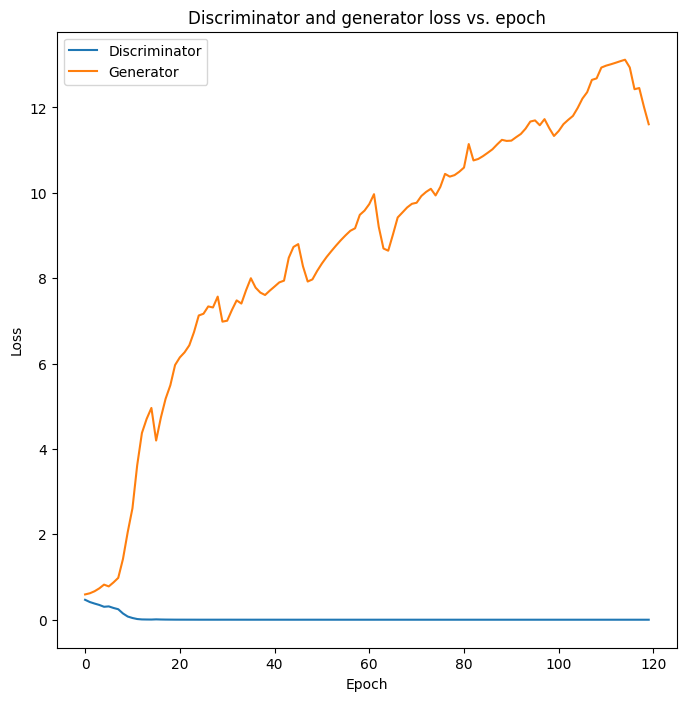

In [11]:
import matplotlib.pyplot as plt    
_, ax = plt.subplots(figsize=(8,8))
ax.plot(history.epoch, history.history['d_loss'], label='Discriminator')
ax.plot(history.epoch, history.history['g_loss'], label='Generator')
ax.set_title('Discriminator and generator loss vs. epoch')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
plt.legend()

In [12]:
noise = keras.random.normal(shape=(1,latent_dim))
noise = ops.repeat(noise, repeats=num_classes)
noise = ops.reshape(noise, (num_classes, latent_dim))

labels = np.arange(num_classes)
labels = keras.utils.to_categorical(labels, num_classes)
noise_and_labels = ops.concatenate([noise, labels], axis=1)

In [13]:
trained_gen = cond_gan.generator
fake = trained_gen.predict(noise_and_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


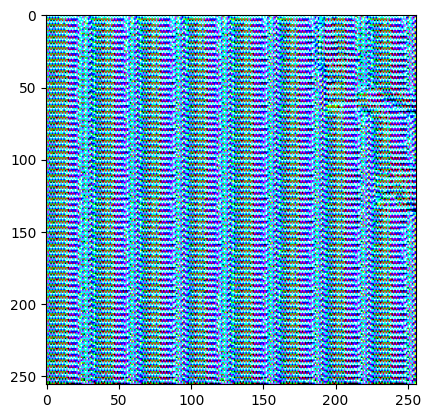

In [16]:
plt.imshow(fake[10])